In [34]:
import os
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from six.moves import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/bmoretz/notebooks/master/MSDS422/Assignment_02/"
DATA_PATH = os.path.join("datasets/bank.csv")
FILE_URL = DOWNLOAD_ROOT + str(DATA_PATH)

RANDOM_SEED = 1

def fetch_bank_data( file_url = FILE_URL, data_path = DATA_PATH):
    if not os.path.isdir( data_path ):
        os.makedirs( data_path )
    urllib.request.urlretrieve(file_url, DATA_PATH)
    
def load_bank_data( file_path = DATA_PATH, sep = ","):
    return pd.read_csv(file_path, sep = sep)

In [2]:
# download data into workspace
if not os.path.isfile(DATA_PATH):
    fetch_bank_data()

# Load the CSV into a DataFrame
bank = load_bank_data(sep = ';')

In [3]:
bank.shape

(4521, 17)

In [4]:
bank.dropna()
bank.shape

(4521, 17)

In [5]:
list(bank.columns.values)

['age',
 'job',
 'marital',
 'education',
 'default',
 'balance',
 'housing',
 'loan',
 'contact',
 'day',
 'month',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'poutcome',
 'response']

In [6]:
# examine the raw data
bank.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,response
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


In [7]:
# mapping function to convert text no/yes to integer 0/1
convert_to_binary = {'no' : 0, 'yes' : 1}

In [8]:
# Convert yes/no string to binary
default = bank['default'].map(convert_to_binary)
housing = bank['housing'].map(convert_to_binary)
loan = bank['loan'].map(convert_to_binary)
response = bank['response'].map(convert_to_binary)

In [9]:
model_data = np.array( [np.array(default), np.array(housing), np.array(loan), np.array(response)]).T

In [10]:
model_data.shape

(4521, 4)

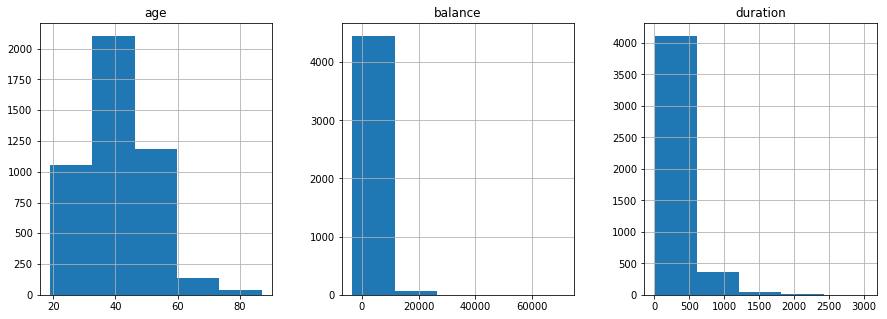

In [61]:
distributions = bank[['age', 'balance', 'duration']].hist( bins = 5, figsize=(15, 5), layout=(1,3))

In [62]:
# Use age distribution to cut into bins
bank['age_group'] = pd.cut(bank.age, bins=[g for g in range(20, 90, 5)], include_lowest=True)
bank.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,response,age_group
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no,"(25.0, 30.0]"
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no,"(30.0, 35.0]"
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no,"(30.0, 35.0]"
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no,"(25.0, 30.0]"
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no,"(55.0, 60.0]"


<Figure size 432x288 with 0 Axes>

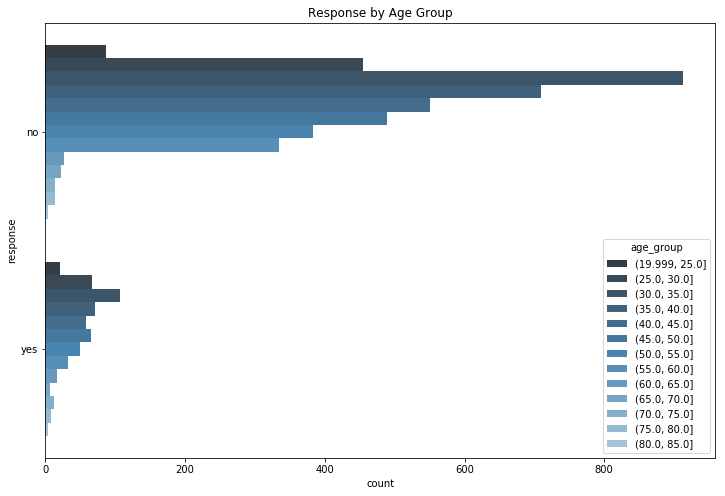

In [63]:
fig=plt.figure()
fig, ax = plt.subplots(figsize=(12,8))
sns.countplot(y='response', hue='age_group', data=bank, palette="Blues_d")
plt.title('Response by Age Group')
plt.show()